<a href="https://colab.research.google.com/github/rhiats/titanicPrediction/blob/main/titanicPred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Titanic - Machine Learning from Disaster**

References:

https://www.kaggle.com/competitions/titanic/data

https://towardsdatascience.com/a-beginners-guide-to-kaggle-s-titanic-problem-3193cb56f6ca

https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/problem12.html

https://anelmusic13.medium.com/how-to-score-top-3-in-kaggles-titanic-machine-learning-from-disaster-competition-13d056e262b1


The Titanic dataset contains 891 passengers and it is balanced with 40% of the passengers surviving the catastrophe. The dataset is skewed towards males, with 80% of the data composed of male passengers. There were more males included in this Titanic dataset than females, but it is unclear whether there were more males on the ship than females. Most of the data is categorical, with the only continuous data included being Age and Fare.

Only three of the columns are missing values. The three columns are Ages, Cabin, and Embarked. There are 177 passengers missing Ages, 687 missing Cabin numbers, and 2 missing from Embarked.

Preliminary analysis showed that it is more likely that a female survives the crash than a male, while it equally likely that an adult and child survive the crash. An adult is considered a person older than 16 years of age. Both children and adults have a 40% chance of surviving the incident. Age is not included as a feature for the model. Families with 4 or more children/parents had a higher chance of dying in the crash. Similarly, families with 3 of more siblings had an increased chance of dying during the crash, so these factors are considered in the analysis. The fare of the passengers who survived the crash are significantly different, so fare is not considered as a feature in the analysis. It is more likely that a passenger in Class 1 than Class 3 survive the crash.


In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

**Exploring the Training Set**

In [2]:
def duplicates(df,cols_lst):
  """
    Return df of duplicate rows across specified across columns
    https://www.statology.org/pandas-find-duplicates/

    @p:
    df (df): dataframe containing rows and columns (not empty)
    cols (list): list of columns to ck for duplicates

    @r:
    dups_df (df): Dataframe containing the duplicate rows
  """

  return df[df.duplicated(cols_lst)]

In [3]:
X=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/titanicPrediction/input/train.csv")
y=X.Survived
X.drop(['Name', 'Ticket', 'Cabin','Embarked'], axis=1,inplace=True)
dupPassengers_df=duplicates(X,['PassengerId'])

In [4]:
print(X.head())
print("The are {} duplicated passengers in the dataset".format(int(dupPassengers_df.shape[0])))
print("The are {} passengers in the dataset".format(int(X.shape[0])))

   PassengerId  Survived  Pclass     Sex   Age  SibSp  Parch     Fare
0            1         0       3    male  22.0      1      0   7.2500
1            2         1       1  female  38.0      1      0  71.2833
2            3         1       3  female  26.0      0      0   7.9250
3            4         1       1  female  35.0      1      0  53.1000
4            5         0       3    male  35.0      0      0   8.0500
The are 0 duplicated passengers in the dataset
The are 891 passengers in the dataset


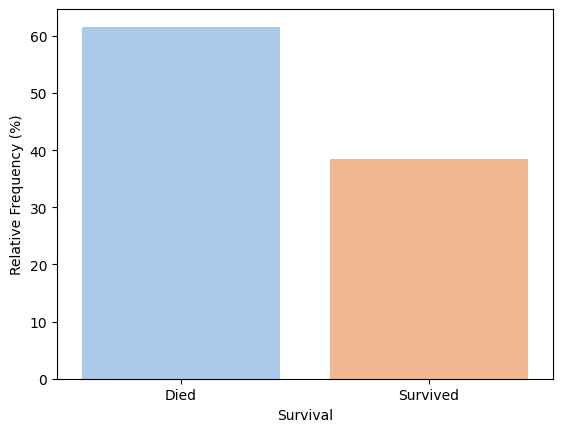

In [5]:
def balanced(df):
  """
    Percentage of passengers who survive v. not survive in the dataset
    Balanced or Imbalanced Data

    @p:
      df (dataframe): Input dataframe
  """
  df['Survival'] = np.where(df['Survived']==0, 'Died', 'Survived')

  survival_ratio_df=(df[['Survival', 'PassengerId']].groupby('Survival').count()/int(df.shape[0]))*100

  survival_ratio_df.reset_index(inplace=True)

  survival_ratio_df.rename(columns={"PassengerId": "Relative Frequency (%)"}, inplace=True)

  sns.barplot(data=survival_ratio_df, x='Survival', y="Relative Frequency (%)", palette="pastel")

  plt.savefig("/content/drive/MyDrive/Colab Notebooks/titanicPrediction/output/balanced.png")

balanced(X)

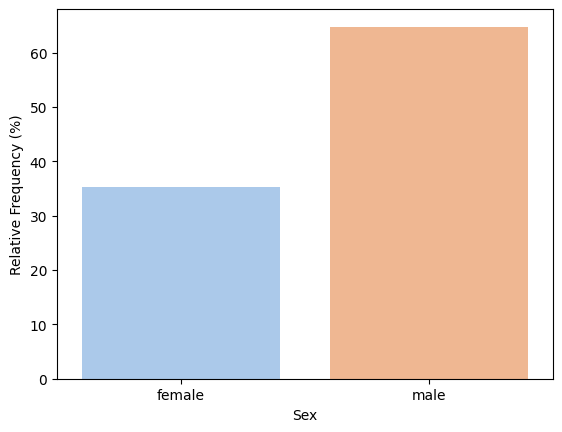

In [6]:
def balanced_sex(df):
  """
    Percentage of passengers by sex
    Balanced or Imbalanced Data

    @p:
      df (dataframe): Input dataframe
  """

  sex_ratio_df=(df[['Sex', 'PassengerId']].groupby('Sex').count()/int(df.shape[0]))*100

  sex_ratio_df.reset_index(inplace=True)

  sex_ratio_df.rename(columns={"PassengerId": "Relative Frequency (%)"}, inplace=True)

  sns.barplot(data=sex_ratio_df, x='Sex', y="Relative Frequency (%)", palette="pastel")

  plt.savefig("/content/drive/MyDrive/Colab Notebooks/titanicPrediction/output/balanced_sex.png")

balanced_sex(X)

In [7]:
def nan_num(df):
  """
    Return the number of nans per column in the data set.

  """
  nan_count=df.isna().sum()
  return nan_count
nan_num(X)

PassengerId      0
Survived         0
Pclass           0
Sex              0
Age            177
SibSp            0
Parch            0
Fare             0
Survival         0
dtype: int64

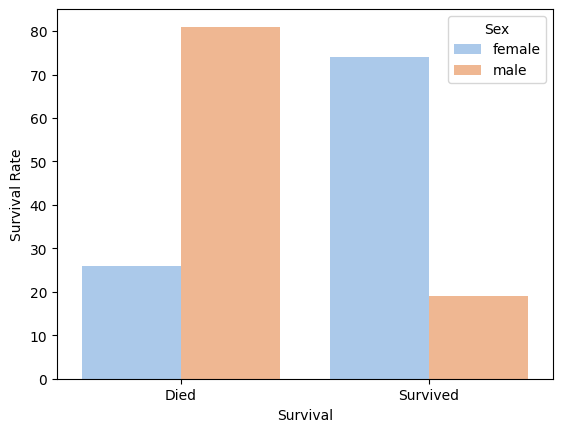

In [8]:
def sex_survival(df):
  """
    Probability Females Survived v. Males survive (Conditional Probability)

    @p:
      df (dataframe): Input dataframe
  """
  df['Survival'] = np.where(df['Survived']==0, 'Died', 'Survived')

  survival_sx_df=df[['Survival', 'Sex', 'PassengerId']].groupby(['Sex','Survival']).count()

  survival_sx_df.reset_index(inplace=True)

  survival_sx_df.rename(columns={"PassengerId": "Count Survived"}, inplace=True)

  sx_df=df[['Sex', 'PassengerId']].groupby(['Sex']).count()

  sx_df.reset_index(inplace=True)

  sx_df.rename(columns={"PassengerId": "Count"}, inplace=True)

  sx_survival_df=pd.merge(survival_sx_df,sx_df,on="Sex")

  sx_survival_df["Survival Rate"]=round((sx_survival_df["Count Survived"]/sx_survival_df["Count"])*100,0)

  sns.barplot(data=sx_survival_df, x="Survival", y="Survival Rate", hue="Sex", palette="pastel")

  plt.savefig("/content/drive/MyDrive/Colab Notebooks/titanicPrediction/output/sex_survival_rate.png")

sex_survival(X)


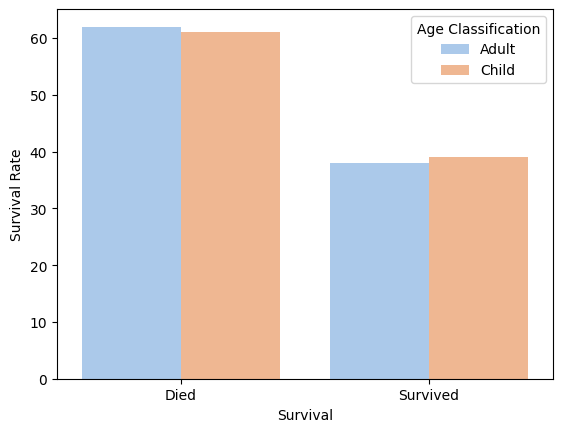

In [9]:
def age_survival(df):
  """
    Probability Adults (Age 16) survive the Titanic crash (Conditional Probability)

    @p:
      df (dataframe): Input dataframe
  """
  df['Survival'] = np.where(df['Survived']==0, 'Died', 'Survived')

  df['Age Classification']=np.where((df['Age']>16), "Adult", "Child")

  survival_age_df=df[['Survival', 'Age Classification', 'PassengerId']].groupby(['Age Classification','Survival']).count()

  survival_age_df.reset_index(inplace=True)

  survival_age_df.rename(columns={"PassengerId": "Count Survived"}, inplace=True)

  age_df=df[['Age Classification', 'PassengerId']].groupby(['Age Classification']).count()

  age_df.reset_index(inplace=True)

  age_df.rename(columns={"PassengerId": "Count"}, inplace=True)

  age_survival_df=pd.merge(survival_age_df,age_df,on="Age Classification")

  age_survival_df["Survival Rate"]=round((age_survival_df["Count Survived"]/age_survival_df["Count"])*100,0)

  sns.barplot(data=age_survival_df, x="Survival", y="Survival Rate", hue="Age Classification", palette="pastel")

  plt.savefig("/content/drive/MyDrive/Colab Notebooks/titanicPrediction/output/adult_survival_rate.png")

age_survival(X)

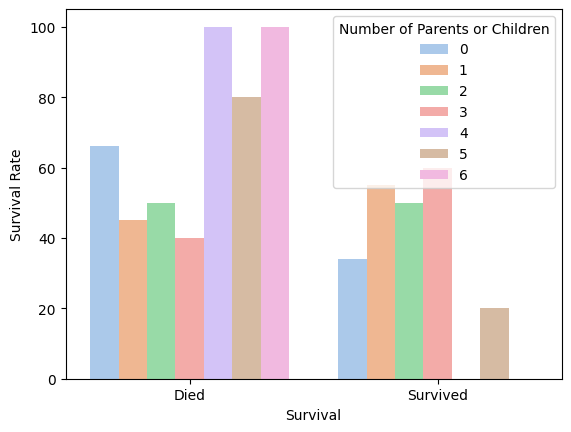

In [10]:
def par_survival(df):
  """
    Probability number of parents influence survival (Conditional Probability)

    @p:
      df (dataframe): Input dataframe
  """
  df['Survival'] = np.where(df['Survived']==0, 'Died', 'Survived')

  df.rename(columns={"Parch": "Number of Parents or Children"}, inplace=True)

  survival_par_df=df[['Survival', 'Number of Parents or Children', 'PassengerId']].groupby(['Number of Parents or Children','Survival']).count()

  survival_par_df.reset_index(inplace=True)

  survival_par_df.rename(columns={"PassengerId": "Count Survived"}, inplace=True)

  par_df=df[['Number of Parents or Children', 'PassengerId']].groupby(['Number of Parents or Children']).count()

  par_df.reset_index(inplace=True)

  par_df.rename(columns={"PassengerId": "Count"}, inplace=True)

  par_survival_df=pd.merge(survival_par_df,par_df,on="Number of Parents or Children")

  par_survival_df["Survival Rate"]=round((par_survival_df["Count Survived"]/par_survival_df["Count"])*100,0)

  sns.barplot(data=par_survival_df, x="Survival", y="Survival Rate", hue="Number of Parents or Children", palette="pastel")

  plt.savefig("/content/drive/MyDrive/Colab Notebooks/titanicPrediction/output/par_survival_rate.png")

par_survival(X)

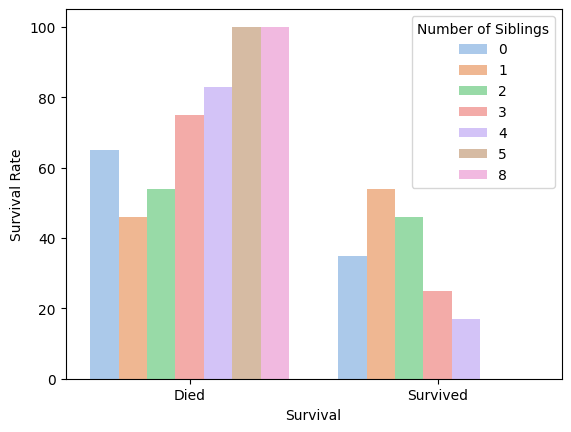

In [11]:
def sib_survival(df):
  """
    Probability siblings influence survival (Conditional Probability)

    @p:
      df (dataframe): Input dataframe
  """
  df['Survival'] = np.where(df['Survived']==0, 'Died', 'Survived')

  df.rename(columns={"SibSp": "Number of Siblings"}, inplace=True)

  survival_sib_df=df[['Survival', 'Number of Siblings', 'PassengerId']].groupby(['Number of Siblings','Survival']).count()

  survival_sib_df.reset_index(inplace=True)

  survival_sib_df.rename(columns={"PassengerId": "Count Survived"}, inplace=True)

  sib_df=df[['Number of Siblings', 'PassengerId']].groupby(['Number of Siblings']).count()

  sib_df.reset_index(inplace=True)

  sib_df.rename(columns={"PassengerId": "Count"}, inplace=True)

  sib_survival_df=pd.merge(survival_sib_df,sib_df,on="Number of Siblings")

  sib_survival_df["Survival Rate"]=round((sib_survival_df["Count Survived"]/sib_survival_df["Count"])*100,0)

  sns.barplot(data=sib_survival_df, x="Survival", y="Survival Rate", hue="Number of Siblings", palette="pastel")

  plt.savefig("/content/drive/MyDrive/Colab Notebooks/titanicPrediction/output/sib_survival_rate.png")

sib_survival(X)

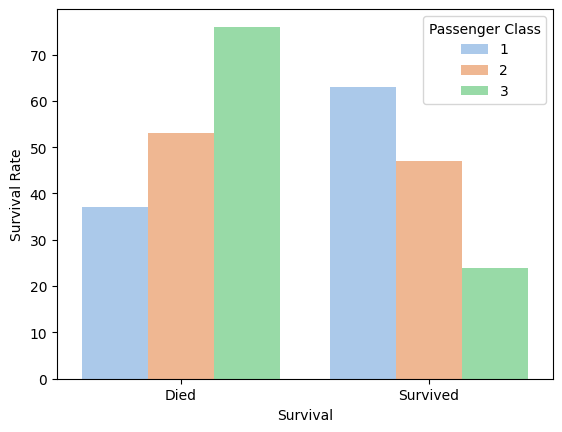

In [12]:
def class_survival(df):
  """
    Probability of a passenger class surviving the crash (Conditional Probability)

    @p:
      df (dataframe): Input dataframe
  """
  df['Survival'] = np.where(df['Survived']==0, 'Died', 'Survived')

  df.rename(columns={"Pclass": "Passenger Class"}, inplace=True)

  survival_class_df=df[['Survival', 'Passenger Class', 'PassengerId']].groupby(['Passenger Class','Survival']).count()

  survival_class_df.reset_index(inplace=True)

  survival_class_df.rename(columns={"PassengerId": "Count Survived"}, inplace=True)

  class_df=df[['Passenger Class', 'PassengerId']].groupby(['Passenger Class']).count()

  class_df.reset_index(inplace=True)

  class_df.rename(columns={"PassengerId": "Count"}, inplace=True)

  class_survival_df=pd.merge(survival_class_df,class_df,on="Passenger Class")

  class_survival_df["Survival Rate"]=round((class_survival_df["Count Survived"]/class_survival_df["Count"])*100,0)

  sns.barplot(data=class_survival_df, x="Survival", y="Survival Rate", hue="Passenger Class", palette="pastel")

  plt.savefig("/content/drive/MyDrive/Colab Notebooks/titanicPrediction/output/class_survival_rate.png")

class_survival(X)

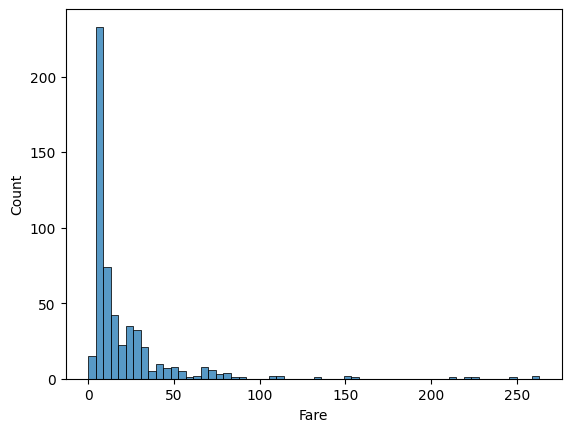

In [13]:
#Distribution of fares - t-test
def survival_distribution_fares(df,survival_type):
  """
    Distribution of survival for fares

    @p:
      df (dataframe): Input dataframe
  """
  df['Survival'] = np.where(df['Survived']==0, 'Died', 'Survived')

  df=df[df['Survival']==survival_type]

  sns.histplot(data=df, x="Fare")

survival_distribution_fares(X,'Died')

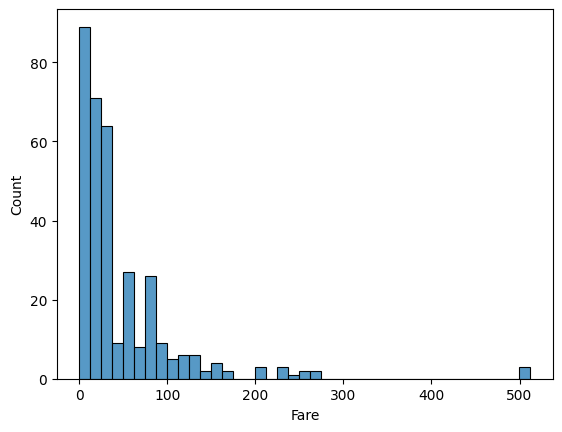

In [14]:
survival_distribution_fares(X,'Survived')

In [15]:
def t_test_survival(df):
  """
    Is the difference between the fare of
    the passengers who survived significantly different from those who died?

    https://www.datacamp.com/tutorial/an-introduction-to-python-t-tests?utm_source=google&utm_medium=paid_search&utm_campaignid=19589720830&utm_adgroupid=143216588377&utm_device=c&utm_keyword=&utm_matchtype=&utm_network=g&utm_adpostion=&utm_creative=661628555645&utm_targetid=dsa-1947282172981&utm_loc_interest_ms=&utm_loc_physical_ms=9004416&utm_content=dsa~page~community-tuto&utm_campaign=230119_1-sea~dsa~tutorials_2-b2c_3-us_4-prc_5-na_6-na_7-le_8-pdsh-go_9-na_10-na_11-na&gclid=CjwKCAjwivemBhBhEiwAJxNWNyNhPMWI2_jEAUejU7VXHpPFlhbQYhS5W2wSmKHL-KiPZUM-DzKitBoCqS8QAvD_BwE

  """

  df['Survival'] = np.where(df['Survived']==0, 'Died', 'Survived')

  df_died=df[df['Survival']=='Died']

  df_survive=df[df['Survival']=='Survived']

  N1, N2 = df_died.shape[0], df_survive.shape[0]

  # Degrees of freedom
  dof = min(N1,N2) - 1
  print(dof)

  # Gaussian distributed data with mean of fare who died and var = 1
  x = np.random.randn(N1) + df_died["Fare"]

  # Gaussian distributed data with mean of fare who survived and var = 1
  y = np.random.randn(N2) + df_survive["Fare"]

  ## Using the internal function from SciPy Package
  t_stat, p_val = stats.ttest_ind(x, y, equal_var = False)
  print("t-statistic = " + str(t_stat))
  print("p-value = " + str(p_val))

t_test_survival(X)

341
t-statistic = -6.827574081506906
p-value = 2.905361529916442e-11


Two potential models that could be used to predict the survival of a passenger on the Titanic are **Multi-variable Logistic Regression** and a **Decision Tree Classifier**. They are both simple models that can be highly effective on small datasets. Continuous predictors work best for Logistic Regression models, while categorical data is beneficial for a Decision Tree classifier, so the selected features are categorized for the analytics.

The models are evaluated using **Mean Squared Error (MSE)**, which is the average squared difference between the predicted and actual values. A lower value indicate better performance of the model. Also, evaluated on **accuracy** since the dataset is balanced. A **ROC** Curve is used to measure the True Positive and False Positive balance.

**Decision Tree Model (Train, Predict, Validate)**

https://samanemami.medium.com/evaluate-the-decision-regressor-tree-d8394d753ae7#:~:text=The%20performance%20of%20a%20decision,Lower%20values%20indicate%20better%20performance.

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error,accuracy_score

df=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/titanicPrediction/input/train.csv")

df=df.replace('male', 0)
df=df.replace('female', 1)

X=df[['Pclass','Sex','SibSp','Parch','Fare']]
y=df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
clf = DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)
print("The mean squared error is {}".format(mean_squared_error(y_test, y_pred)))
print("The accuracy is {}".format(accuracy_score(y_test, y_pred)))

The mean squared error is 0.2271186440677966
The accuracy is 0.7728813559322034


**Random Forest (Train, Predict, Validate)**

https://samanemami.medium.com/evaluate-the-decision-regressor-tree-d8394d753ae7#:~:text=The%20performance%20of%20a%20decision,Lower%20values%20indicate%20better%20performance.

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error,accuracy_score,roc_curve

df=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/titanicPrediction/input/train.csv")

df=df.replace('male', 0)
df=df.replace('female', 1)

X=df[['Pclass','Sex','SibSp','Parch','Fare']]
y=df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
clf = RandomForestClassifier(random_state=0)
clf = clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)
print("The mean squared error is {}".format(mean_squared_error(y_test, y_pred)))
print("The accuracy is {}".format(accuracy_score(y_test, y_pred)))

The mean squared error is 0.22033898305084745
The accuracy is 0.7796610169491526


The Decicion Tree Model performs with an accuracy of 79% and the Random Forest model performs with an accuracy of 78%. Both have a Mean Squared (MSE) of ~0.22. The **Random Forest Model** is selected for predicting whether a passenger lives of not on the Titanic. Feature analysis is performed on the Random Forest model to better understand the influence of each feature on the performance of the classification of passengers.

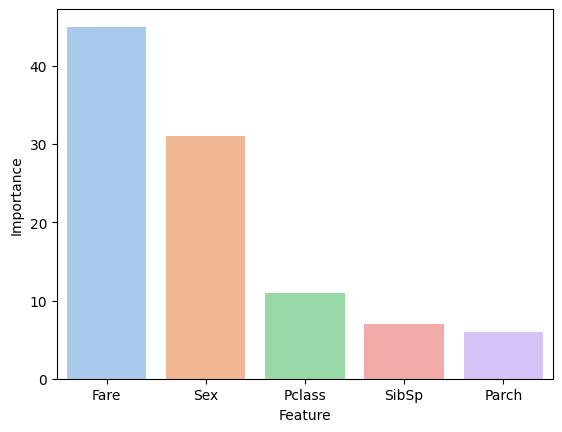

In [18]:
features_lst=['Pclass','Sex','SibSp','Parch','Fare']
importance=clf.feature_importances_.tolist()
rounded_imp_per = [np.round(x,2)*100 for x in importance]
feature_importances_dict = {'Feature': features_lst, 'Importance': rounded_imp_per}
feature_imp_df=pd.DataFrame.from_dict(feature_importances_dict)
feature_imp_df.sort_values(by=['Importance'],ascending=False,inplace=True)

sns.barplot(data=feature_imp_df, x="Feature", y="Importance", palette="pastel")
plt.savefig("/content/drive/MyDrive/Colab Notebooks/titanicPrediction/output/feature_importance_random_forest.png")

Fare and Sex are the two most important features used to classify whether a passenger on the Titanic survives or dies in the Random Forest model. The **Fare per person** (Fare/Family Size) is calculated as a feature for the model to minimize the redundancy of information. Family Size is the sum of siblings, children and parents on the ship. These factors influence the survival of a passenger on the ship. The model is simplified from five features to three features. The **three features** are Passenger Class, Passenger Sex, and Fare per Person.



In [24]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error,accuracy_score,roc_curve

df=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/titanicPrediction/input/train.csv")

df=df.replace('male', 0)
df=df.replace('female', 1)

X=df[['Pclass','Sex','SibSp','Parch','Fare']]

X['Family Size']=X['SibSp']+X['Parch']+1 #Add 1 to include the passenger referenced

X['Fare_per_person']=X['Fare']/X['Family Size']
X['Fare_per_person'].describe()

<ipython-input-24-1bac3624a55a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Family Size']=X['SibSp']+X['Parch']
<ipython-input-24-1bac3624a55a>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Fare_per_person']=X['Fare']/X['Family Size']
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


count    876.000000
mean            inf
std             NaN
min        1.320833
25%       23.750000
50%             NaN
75%             NaN
max             inf
Name: Fare_per_person, dtype: float64

In [ ]:
X[['Pclass','Sex','Fare_per_person']]
y=df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
clf = RandomForestClassifier(random_state=0)
clf = clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)
print("The mean squared error is {}".format(mean_squared_error(y_test, y_pred)))
print("The accuracy is {}".format(accuracy_score(y_test, y_pred)))

There are **three next steps** that may improve the analysis of this dataset.

1. Balance by sex of the passenger
2. Impute the ages of the missing passengers and use a two tail t-test to determine how the avergae ages of the passengers who live and don't differ
3. Bin the Fare so that minute variations do not sway the model

**Test Set**



In [19]:
df=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/titanicPrediction/input/test.csv")

df=df.replace('male', 0)
df=df.replace('female', 1)

X=df[['Pclass','Sex','SibSp','Parch','Fare']]
y_pred=clf.predict(X)

ValueError: ignored